In [73]:
import numpy as np
import pandas as pd
from urllib2 import Request, urlopen
import json
import sys
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
# import scipy as sp
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn.cross_validation import KFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
# from statsmodels.regression.linear_model import OLS
# import sklearn.preprocessing as Preprocessing
# from sklearn.preprocessing import StandardScaler as Standardize
# import itertools as it
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.tree import DecisionTreeClassifier as DecisionTree
# from sklearn.ensemble import RandomForestClassifier as RandomForest
# from sklearn.svm import SVC
# from sklearn.cross_validation import train_test_split
# from sklearn import discriminant_analysis
# from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [27]:
data_2015 = pd.read_json("json_2015.json")
data_2015.head(n=5)

,business_id,cool,date,funny,stars,text,useful,user_id
0,vT12uXtdBQ10_lUcl-M40w,0,2015-01-01,0,1,terrible experience....I am a local first of a...,0,C_xtIn19eKivN335dzjadg
1,aWMxTWSEqBvH2KhdGPLibQ,0,2015-01-01,0,3,Bad service at this location.\n\nGood iced cof...,0,T7J9ae0wTskrI_Bgwp-4cA
2,Z98h1BhssZeFfZvcVTYOpw,0,2015-01-01,0,2,We have been to Maya's many times since it fir...,1,O7WaUuYwX45Ia6Mvf01UCw
3,3rwM9fPYPk9qDkEBOhyHbg,1,2015-01-01,0,5,"booked the hotel for new years, over the phone...",1,kq-4vbC1cHQbRKyDmwERSA
4,JpYn_HdxQNZQSlWWv4P6Iw,0,2015-01-01,0,3,"Good, not great. Not a ton of tea options but ...",1,XweddetOpWNuJQ5mLb_5JQ


In [83]:
rand_1400 = data_2015.sample(frac=.0021)
rand_1400.head()

,business_id,cool,date,funny,stars,text,useful,user_id
566922,5rDosv0aIBhLg81IMSnlyg,1,2015-11-04,1,5,I've been here twice this year and enjoyed it ...,1,2rr2tYFR4AXj1DEYv8Qwtw
460555,A3Jv-FFRsDEWXxKJ6ZIxfg,0,2015-09-08,1,1,A total disappointment across the board. Servi...,1,bUHk3KgyEz0edqfi_UJuEw
512536,Lm_icydEIPlyPTARvMZUsw,1,2015-10-05,0,5,Modern and cool. The hotel is styled simply a...,1,pFPj7dz3PSxAwJxdkDVo1Q
83400,2zJbG645xRdTfAprhaVQTQ,0,2015-02-20,1,5,Love Love Love this place! Amazing Mexican foo...,0,TBVKqs5sqEw0dOPp_xBR0Q
437610,63rmr1oM0BbAXcUfNEaieQ,3,2015-08-27,1,3,"I really didn't want to come here, because I r...",4,Hys6HzKi24j2809kI_7dKA


Range of Review Lengths: 2 words - 952 words
Mean of Review Lengths: 106.446428571


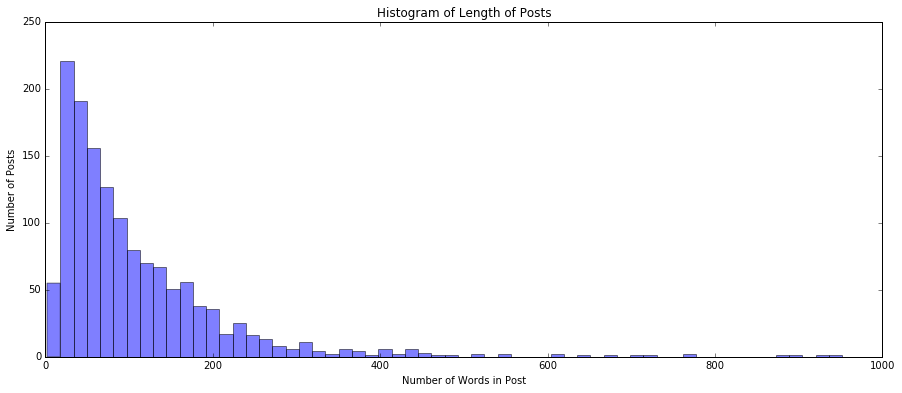

In [84]:
lengths = rand_1400['text'].apply(lambda x: len(x.split(' ')))

print 'Range of Review Lengths: {0} words - {1} words'.format(np.min(lengths), np.max(lengths))
print 'Mean of Review Lengths: {}'.format(np.mean(lengths))

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Post')
ax.set_ylabel('Number of Posts')
ax.set_title('Histogram of Length of Posts')

plt.show()

In [85]:
#Create a text vectorizer (turns text into array of numbers)
#using a common list of English stop words
vectorizer = CountVectorizer(stop_words='english', min_df=1)

#Get all the text from data
corpus = rand_1400['text'].values

#Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

#Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

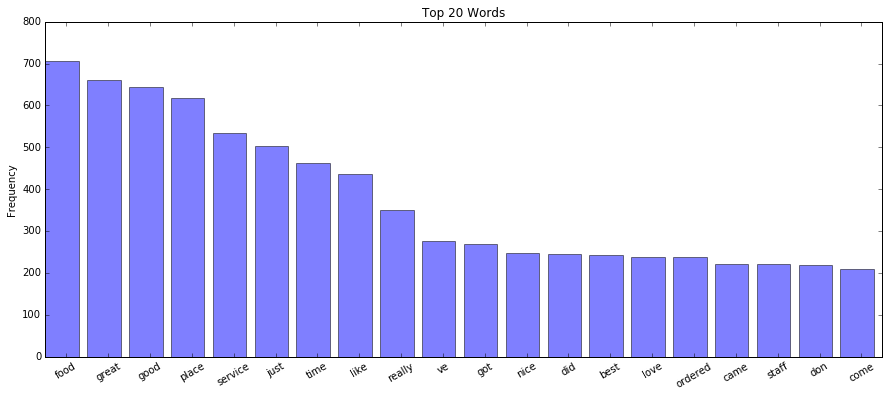

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [87]:
#Encode the class labels (Neg, Pos) as numbers
labels = rand_1400['stars'].values
enc_label = LabelEncoder()
y = enc_label.fit_transform(labels)
# Adjust
y = y + 1

classes labels: [1 2 3 4 5]


In [88]:
#Print the number of comments in each class
print 'Number of 1 star posts:', len(y[y == 1])
print 'Number of 2 star posts:', len(y[y == 2])
print 'Number of 3 star posts:', len(y[y == 3])
print 'Number of 4 star posts:', len(y[y == 4])
print 'Number of 5 star posts:', len(y[y == 5])

Number of 1 star posts: 205
Number of 2 star posts: 112
Number of 3 star posts: 132
Number of 4 star posts: 304
Number of 5 star posts: 647


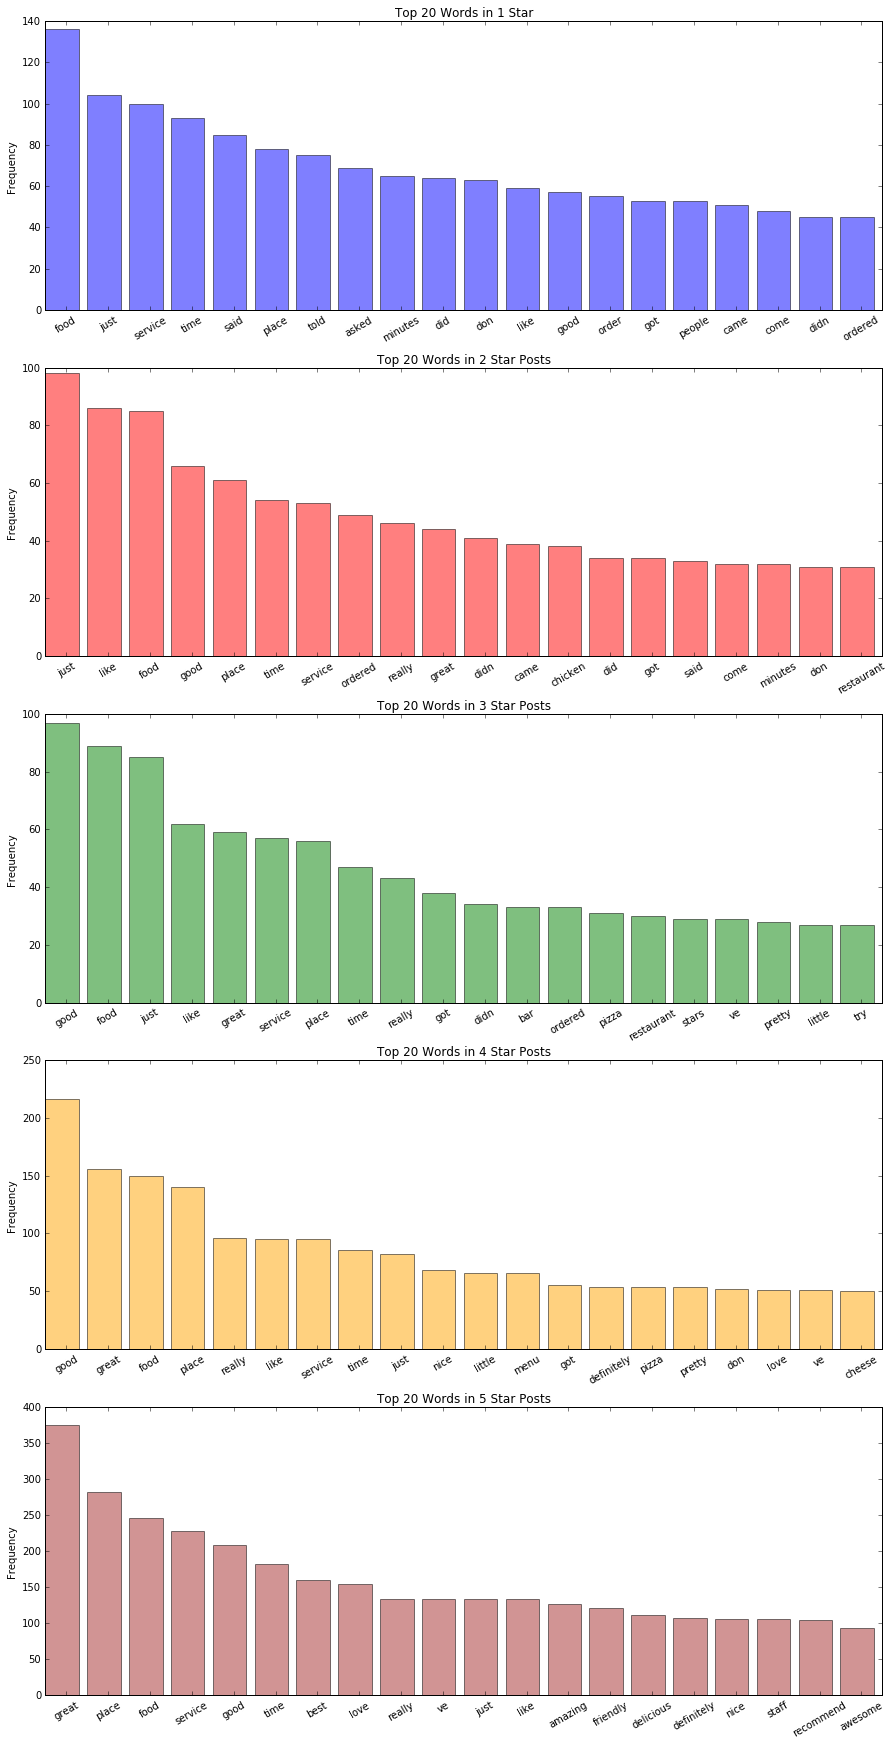

In [89]:
fig, ax = plt.subplots(5, 1, figsize=(15, 30))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

#Count the number of time each word occurs in the 1 stars posts
word_freq = x[y == 1].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[0].bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax[0].set_ylabel('Frequency')
ax[0].set_title('Top ' + str(n) + ' Words in 1 Star')

#Label the bars with the top words
ax[0].set_xticks(indices + width)
ax[0].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

#Count the number of time each word occurs in the 2 stars posts
word_freq = x[y == 2].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[1].bar(indices, [word[0] for word in top_words], color='red', alpha=0.5)

ax[1].set_ylabel('Frequency')
ax[1].set_title('Top ' + str(n) + ' Words in 2 Star Posts')

#Label the bars with the top words
ax[1].set_xticks(indices + width)
ax[1].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

#Count the number of time each word occurs in the 3 stars posts
word_freq = x[y == 3].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[2].bar(indices, [word[0] for word in top_words], color='green', alpha=0.5)

ax[2].set_ylabel('Frequency')
ax[2].set_title('Top ' + str(n) + ' Words in 3 Star Posts')

#Label the bars with the top words
ax[2].set_xticks(indices + width)
ax[2].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[2].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

#Count the number of time each word occurs in the 4 stars posts
word_freq = x[y == 4].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[3].bar(indices, [word[0] for word in top_words], color='orange', alpha=0.5)

ax[3].set_ylabel('Frequency')
ax[3].set_title('Top ' + str(n) + ' Words in 4 Star Posts')

#Label the bars with the top words
ax[3].set_xticks(indices + width)
ax[3].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[3].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

#Count the number of time each word occurs in the 5 stars posts
word_freq = x[y == 5].sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Bar plot of the frequencies of the top words
ax[4].bar(indices, [word[0] for word in top_words], color='brown', alpha=0.5)

ax[4].set_ylabel('Frequency')
ax[4].set_title('Top ' + str(n) + ' Words in 5 Star Posts')

#Label the bars with the top words
ax[4].set_xticks(indices + width)
ax[4].set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax[4].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [90]:
# Train/test split
n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]
print x_train.shape
x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=5, 
                    penalty='l2', 
                    Cs=regularization, 
                    solver='liblinear', 
                    n_jobs=4)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on 1 star in test set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])
print 'Accuracy on 2 star in test set:', logistic.score(x_test[y_test == 2], y_test[y_test == 2])
print 'Accuracy on 3 star in test set:', logistic.score(x_test[y_test == 3], y_test[y_test == 3])
print 'Accuracy on 4 star in test set:', logistic.score(x_test[y_test == 4], y_test[y_test == 4])
print 'Accuracy on 5 star in test set:', logistic.score(x_test[y_test == 5], y_test[y_test == 5])

(923, 9564)
Accuracy on overall test set: 0.547169811321
Accuracy on 1 star in test set: 0.542372881356
Accuracy on 2 star in test set: 0.0
Accuracy on 3 star in test set: 0.0
Accuracy on 4 star in test set: 0.576271186441
Accuracy on 5 star in test set: 0.755868544601


In [91]:
#This function computes the accuracy of logistic regression given cut-offs, min_df, max_df
def vectorize_classify(min_df, max_df, trials, x, y):
    #Create a text vectorizer, removing words with frequency less than min_df or
    #greater than max_df
    vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df)
    #Transform our text into arrays of numbers
    corpus = rand_1400['text'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Record overall accuracy rate, accuracy on class 1 and class 0
    overall_acc = []
    class_5_acc = []
    class_4_acc = []
    class_3_acc = []
    class_2_acc = []
    class_1_acc = []
    
    
    n_samples = len(x)
    
    #Perform logistic regression on a handful of train/test splits
    for i in range(trials):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(i + 1)/trials)*100))
        sys.stdout.flush()
        
        # Train/test split
        train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

        x_train = x[train_indices]
        y_train = y[train_indices]

        x_test = x[~train_indices]
        y_test = y[~train_indices]

        #Generate array of L2 regularization parameters
        regularization = 10. ** np.arange(-10, 5)

        #Fit logistic model
        logistic = LogRegCV(cv=5, 
                            penalty='l2', 
                            Cs=regularization, 
                            solver='liblinear', 
                            n_jobs=4)
        logistic.fit(x_train, y_train)
        
        overall_acc.append(logistic.score(x_test, y_test))
        class_1_acc.append(logistic.score(x_test[y_test == 1], y_test[y_test == 1]))
        class_2_acc.append(logistic.score(x_test[y_test == 2], y_test[y_test == 2]))
        class_3_acc.append(logistic.score(x_test[y_test == 3], y_test[y_test == 3]))
        class_4_acc.append(logistic.score(x_test[y_test == 4], y_test[y_test == 4]))
        class_5_acc.append(logistic.score(x_test[y_test == 5], y_test[y_test == 5]))

    return (np.mean(overall_acc), 
            np.mean(class_1_acc),
            np.mean(class_2_acc),
            np.mean(class_3_acc),
            np.mean(class_4_acc),
            np.mean(class_5_acc))

In [92]:
x.shape

(1400, 9564)

In [100]:
# Solution to not identifying class 2 and 3 possibly
min_df = 10
max_df = 50
trials = 10
overall, class_1, class_2, class_3, class_4, class_5 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class 1 in test set:', class_1
print 'Accuracy on class 2 in test set:', class_2
print 'Accuracy on class 3 in test set:', class_3
print 'Accuracy on class 4 in test set:', class_4
print 'Accuracy on class 5 in test set:', class_5

100.0% completed
Min frequency, max frequency: 10 , 50
Accuracy on overall test set: 0.45507558902
Accuracy on class 1 in test set: 0.324157110414
Accuracy on class 2 in test set: 0.216749255049
Accuracy on class 3 in test set: 0.033946134755
Accuracy on class 4 in test set: 0.325172498758
Accuracy on class 5 in test set: 0.681447985375
